# Import

In [1]:
import pyproj
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import cluster
from sklearn import mixture
from matplotlib.pyplot import cm
from shapely.geometry import Point
from sklearn.metrics import silhouette_score
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load Data
### Precipitation

In [2]:
prcp = pd.read_csv("../data/external/nyc_centralpark_2017precip.csv",
                   usecols=["DATE", "PRCP"], parse_dates=["DATE"])
prcp["d"] = prcp.DATE.dt.strftime("%Y-%m-%d")
low_rain = prcp[prcp.PRCP < 0.05]
low_rain.sort_values("DATE", ascending=False).head(2)

,DATE,PRCP,d
247,2017-09-05,0.0,2017-09-05
246,2017-09-04,0.0,2017-09-04


### Cameras

In [3]:
cams = pd.read_csv("../data/external/cameras.csv")
proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
cams["lat_nys"], cams["lon_nys"] = zip(*[proj(i, j) for i, j in zip(cams.long, cams.lat)])
geometry = [Point(xy) for xy in zip(cams["lat_nys"], cams["lon_nys"])]

cams = gp.GeoDataFrame(cams[["cam_id", "boro", "people"]], 
                        crs={'init': "epsg:2263"}, geometry=geometry)
mn_cams = cams[(cams.boro == "Manhattan") & 
               (cams.people == 1.)
               & (~cams.cam_id.isin([291, 328, 547, 715, 795, 805]))
              ].copy()
mn_cams.sort_values("cam_id", inplace=True)
mn_cams.head(2)

,cam_id,boro,people,geometry
49,163,Manhattan,1,POINT (981537.0830527659 198394.4946422517)
51,165,Manhattan,1,POINT (991206.2687607175 210824.6213360374)


### Manhattan

In [4]:
nyc = gp.read_file("../data/external/nyc_shp/nybb.shp")
nyc = nyc.to_crs({'init': "epsg:2263"})

### Hadive

In [5]:
hdv = pd.read_feather("../data/results/hadive-data.feather").set_index("date")
mn_wd_hdv = hdv[(hdv.cam_id.isin(mn_cams.cam_id.unique())) & 
                (hdv.index.weekday < 5)].copy()
dt_values = [(t[:10], t[11:16]) for t in (mn_wd_hdv.index.round("5Min").values).astype(str)]
mn_wd_hdv["d"] = [x[0] for x in dt_values]
mn_wd_hdv["t"] = [x[1] for x in dt_values]
mn_wd_hdv = mn_wd_hdv[mn_wd_hdv.d.isin(low_rain.d.unique())]
mn_wd_hdv.head(2)

,cam_id,count,d,t
date,,,,
2017-06-27 23:57:33,988,0,2017-06-28,00:00
2017-06-27 23:57:33,166,0,2017-06-28,00:00


# Analysis
### Find standardized time series for all cameras.

In [6]:
ts_matrix = mn_wd_hdv.groupby(["cam_id", "t"]).mean().unstack(level=1)
ts_matrix.columns = [pd.to_datetime("9-9-99 " + t) for t in ts_matrix.columns.droplevel()]
ts_matrix = ((ts_matrix.T - ts_matrix.T.mean()) / ts_matrix.T.std()).T
ts_matrix.head(2)

,1999-09-09 00:00:00,1999-09-09 00:05:00,1999-09-09 00:10:00,1999-09-09 00:15:00,1999-09-09 00:20:00,1999-09-09 00:25:00,1999-09-09 00:30:00,1999-09-09 00:35:00,1999-09-09 00:40:00,1999-09-09 00:45:00,...,1999-09-09 23:10:00,1999-09-09 23:15:00,1999-09-09 23:20:00,1999-09-09 23:25:00,1999-09-09 23:30:00,1999-09-09 23:35:00,1999-09-09 23:40:00,1999-09-09 23:45:00,1999-09-09 23:50:00,1999-09-09 23:55:00
cam_id,,,,,,,,,,,,,,,,,,,,,
163,-1.152960,-1.138094,-1.146052,-1.153428,-1.152704,-1.14853,-1.158965,-1.146424,-1.150617,-1.163140,...,-1.10813,-1.146404,-1.121802,-1.153240,-1.138221,-1.165208,-1.137189,-1.143312,-1.117312,-1.131054
165,-1.140513,-1.229348,-1.201282,-1.102899,-1.337228,-1.13605,-1.279336,-1.217505,-1.277460,-1.242833,...,-0.99424,-0.896306,-0.969917,-1.140998,-0.843385,-1.033756,-1.133163,-1.315183,-1.204168,-1.064656


### Find difference of each camera from the mean manhattan camera and cluster.

In [7]:
ts_diff = ts_matrix - ts_matrix.mean()

In [8]:
for n_clusters in range(2, 12):
    clust = cluster.KMeans(n_clusters=n_clusters, )
    clust_labels = clust.fit_predict(ts_diff)
    print "For {} clusters, the average silhouette score is: {}".format(
        n_clusters, silhouette_score(ts_diff, clust_labels))

For 2 clusters, the average silhouette score is: 0.131540830621
For 3 clusters, the average silhouette score is: 0.0823998352795
For 4 clusters, the average silhouette score is: 0.0878851528818
For 5 clusters, the average silhouette score is: 0.0890240886683
For 6 clusters, the average silhouette score is: 0.062473198256
For 7 clusters, the average silhouette score is: 0.0827656031712
For 8 clusters, the average silhouette score is: 0.0494128496853
For 9 clusters, the average silhouette score is: 0.0541508127059
For 10 clusters, the average silhouette score is: 0.0651440510627
For 11 clusters, the average silhouette score is: 0.0679117315555


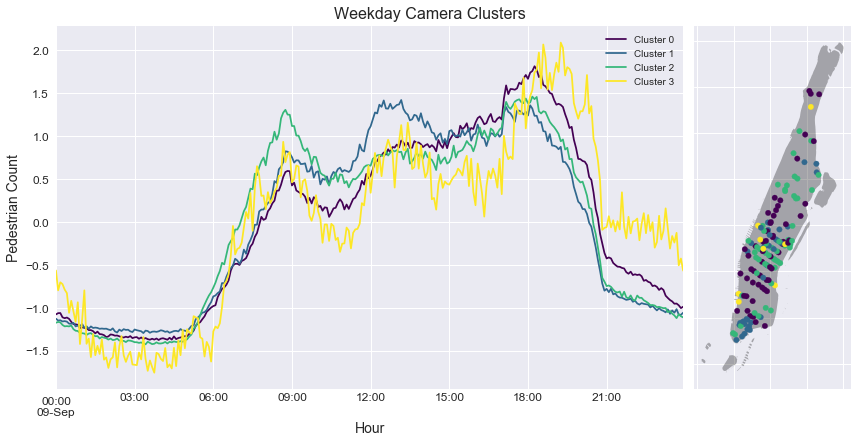

In [13]:
n_clusters = 4

mn_cams["clust"] = cluster.KMeans(
    n_clusters=n_clusters).fit_predict(ts_diff)
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), 
                               gridspec_kw={"width_ratios": [4, 1]})

nyc[nyc.BoroName == "Manhattan"].plot(facecolor="k", alpha=0.3, ax=ax2)
mn_cams.plot(column="clust", ax=ax2, markersize=30, cmap="viridis")

color = iter(cm.viridis(np.linspace(0, 1, n_clusters)))
for ii in range(n_clusters):
    clust = ts_matrix[(mn_cams.clust == ii).values].mean()
    ((clust - clust.mean()) / clust.std()).plot(
        ax=ax1, c=next(color), label="Cluster {}".format(ii))

ax1.set_xlabel("Hour", fontsize=14)
ax1.set_ylabel("Pedestrian Count", fontsize=14)
ax1.grid(True, which="both")
ax1.tick_params(axis="both", which="both", labelsize=12)
ax1.legend()

ax2.set_xticklabels([])
ax2.set_yticklabels([])

fig.suptitle("Weekday Camera Clusters", 
             y=1.02, fontsize=16)
fig.tight_layout()

In [10]:
mn_cams.groupby("clust").size()

clust
0    17
1    40
2    43
3    51
dtype: int64